<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/02_fuzzy_claims_payments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed

In [2]:
!pip install fuzzy-c-means

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m
from matplotlib.colors import ListedColormap


from kneed import KneeLocator

from sklearn.cluster import KMeans, BisectingKMeans
from fcmeans import FCM

from sklearn.metrics import silhouette_score, silhouette_samples
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer



import warnings

**Info**

**Pagos de Siniestros Realizados por CIIU**

---

Pagos realizados por créditos no pagados (Siniestros) clasificados por CIIU entre el 2009 y el 2018.

**Propósito**
Construir un modelo con la capacidad de segmentar aquellas actividades económicas que provocan pagos de siniestros.


**Aspectos**

- Para cuestiones del ejercicio tomaremos todos los años.
- Aplicación del fuzzy
- El factor a segmentar ciiu.

**path data**: https://www.datos.gov.co/Econom-a-y-Finanzas/Pagos-de-Siniestros-Realizados-por-CIIU/t3ws-gv3u

**Suministró los datos:**
Fondo Nacional de Garantías S.A.

**Config**

In [4]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.simplefilter("ignore")
title_data = 'Pagos de Siniestros Realizados por CIIU'
paleta = sns.color_palette("tab10").as_hex()

**Funciones**

In [5]:
def null_features_per_record(data, figsize=(9,8), **kwargs):
  """Identifica el número de caracteristicas nulas por registro"""
  plt.figure(figsize=figsize)
  (
      data
      .isnull()
      .transpose()
      .pipe(
          lambda df: (
              sns.heatmap(
                  data = df

              ).set(**kwargs)
          )
      )
  )


def plot_select_params(best_score, best_x_param, scores, x_params, **kwards):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores)
  ax.plot(best_x_param, best_score, marker='o', color='r')
  ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])

def silhouette_select_cluster(model, clusters, data, **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg

  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())
  kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

  best_score = valores_medios_silhouette[kneedle.elbow]
  best_cluster = kneedle.elbow

  res_data = {
      'score': best_score,
      'cluster': best_cluster,
  }
  plot_select_params(best_score, best_cluster, y, range_n_clusters,
                        title = f'Evolución de media de los índices silhouette {kwards["name_model"]}',
                        ylabel = 'Media índices silhouette',
                        xlabel = 'Numero clusters')

  return best_cluster, best_score


def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


**Data**

In [6]:
# Data de los pagos
url='https://drive.google.com/file/d/1ZC4B3iRcuLBQB-dkEJ9-ImH3s9N9kym2/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
data = pd.read_csv(url, dtype=str)

# Data ciiu
url = "https://docs.google.com/spreadsheets/d/1oG78bIGH5Me6Y_kkdyZH77J_46flqdTr/edit?usp=sharing&ouid=109330320100851020104&rtpof=true&sd=true"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
ciuu = pd.read_excel(url, dtype=str)
ciuu

,AÑO,CIIU,Descripción
0,2018,0,Sin CIIU
1,2018,"7,310",Publicidad
2,2018,"4,321",Instalaciones eléctricas
3,2018,111,"Cultivo de cereales (excepto arroz), legumbres..."
4,2018,112,Cultivo de arroz
...,...,...,...
1407,2020,"9,603",Pompas fúnebres y actividades relacionadas
1408,2020,"9,609",Otras actividades de servicios personales n.c.p.
1409,2020,"9,700",Actividades de los hogares individuales como e...
1410,2020,"9,810",Actividades no diferenciadas de los hogares in...


In [7]:
data.columns

Index(['ano', 'ciiu', 'siniestros', 'valor'], dtype='object')

In [8]:
data.head()

,ano,ciiu,siniestros,valor
0,2005,10,112,277074887.54
1,2005,90,618,2751063144
2,2005,114,2,47756360
3,2005,117,1,6940125
4,2005,122,6,78253979


In [9]:
# Conversión tipo de datos
data[['ano', 'siniestros']] = data[['ano', 'siniestros']].astype('int32')
data[['valor']] = data[['valor']].astype('float64')

In [10]:
data.head()

,ano,ciiu,siniestros,valor
0,2005,10,112,"277,074,887.54"
1,2005,90,618,"2,751,063,144.00"
2,2005,114,2,"47,756,360.00"
3,2005,117,1,"6,940,125.00"
4,2005,122,6,"78,253,979.00"


**EDA**

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9197 entries, 0 to 9196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ano         9197 non-null   int32  
 1   ciiu        9180 non-null   object 
 2   siniestros  9197 non-null   int32  
 3   valor       9197 non-null   float64
dtypes: float64(1), int32(2), object(1)
memory usage: 215.7+ KB


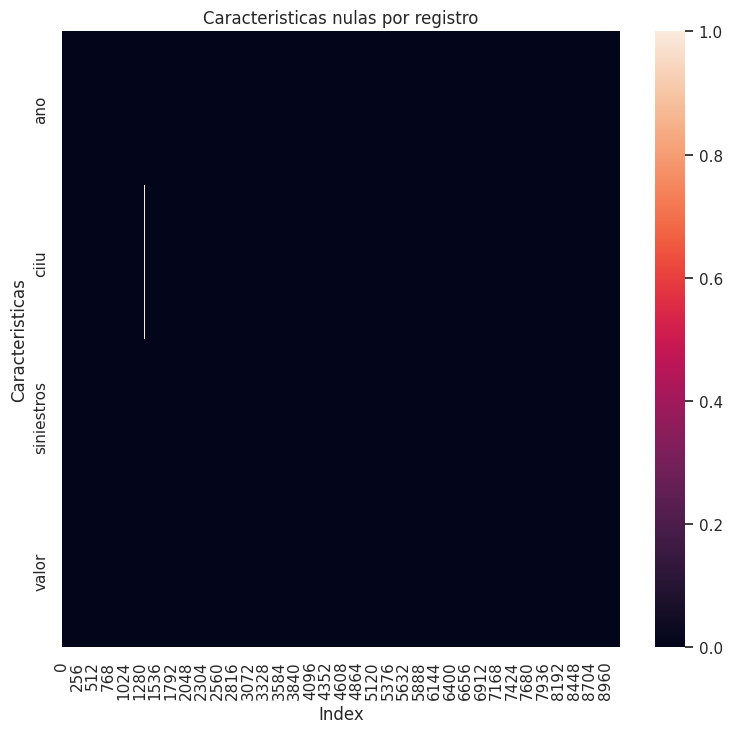

In [12]:
null_features_per_record(
    data,
    title="Caracteristicas nulas por registro",
    xlabel='Index',
    ylabel='Caracteristicas')


In [13]:
data['ciiu'].isnull().sum()

17

- Hay un porcentaje de valores nulos en la columna ciiu, pero es mínimo (17 registros).

In [14]:
len(data['ano'].unique()), len(data['ciiu'].unique())

(18, 810)

- Hay información de 18 años
- Hay información de 810 actividades economicas

In [15]:
data.columns

Index(['ano', 'ciiu', 'siniestros', 'valor'], dtype='object')

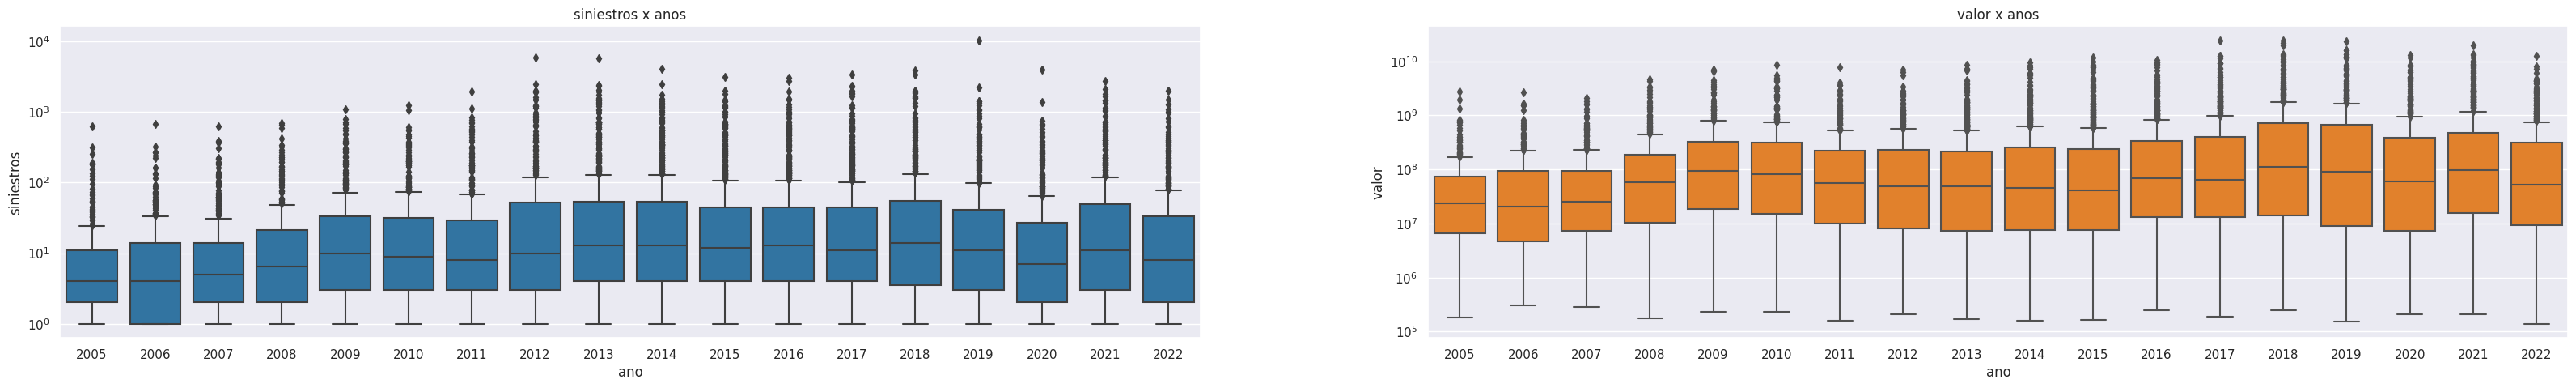

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(40, 5))

sns.boxplot(data=data, x='ano', y='siniestros', ax=ax[0], color=paleta[0])
ax[0].set_title('siniestros x anos')
ax[0].set(yscale="log")
sns.boxplot(data=data, x='ano', y='valor', ax=ax[1], color=paleta[1])
ax[1].set_title('valor x anos')
ax[1].set(yscale="log")
plt.show()

Cada año tiene muchos valores atípicos, tanto en siniestros, como en los valores de los Pagos de Siniestros a los Ciiu. Para ver la distribución se tuvo que visualizar las escala logaritmo.


- En el 2006 se aprecia que la mayoría de los registros indican un número bajo de siniestros que se concentran por debajo de la mediana, con respecto a otros años.


- En el 2012 se aprecia que la mayoría de los registros indican un número alto de siniestros que se concentran por encima de la mediana, con respecto a otros años.


- Como la visualización está en escala logarítmica, es difícil validar el criterio, pero con respecto a los siniestros la mayoría de años no indican un reporte con asimetrías significativa, a diferencia del año 2006 y 2012

- Los pagos en su gran mayoría se encuentran concentrados en los cantiles superiores, por lo tanto, la mayoría de pagos por la cantidad siniestros con respecto al año son considerables, ahora en comparación de los grupos no hay fluctuaciones significativas, pero toca validar, ya que los datos están en escala logarítmica.




In [17]:
data[data['ano'] == 2006].describe()

,ano,siniestros,valor
count,339.00,339.00,339.00
mean,"2,006.00",18.61,"101,518,392.67"
std,0.00,52.60,"243,371,495.24"
min,"2,006.00",1.00,"306,530.00"
25%,"2,006.00",1.00,"4,699,919.00"
50%,"2,006.00",4.00,"20,408,528.00"
75%,"2,006.00",14.00,"93,609,998.50"
max,"2,006.00",679.00,"2,629,491,102.00"


In [18]:
data[data['ano'] == 2012].describe()

,ano,siniestros,valor
count,453.00,453.00,453.00
mean,"2,012.00",114.79,"273,224,577.87"
std,0.00,393.90,"683,382,855.54"
min,"2,012.00",1.00,"210,000.00"
25%,"2,012.00",3.00,"8,002,040.00"
50%,"2,012.00",10.00,"48,156,414.00"
75%,"2,012.00",52.00,"230,727,274.00"
max,"2,012.00","5,881.00","6,966,250,547.00"


Se aprecia en la primera tabla que mediana del 2006 es menor a la del 2012, lo cual indica que para el año 2006 por registro se reportaron menos siniestros.

In [19]:
# Primera agrupación
function_dictionary = {
    'siniestros': ['sum'],
    'valor': ['sum'],

}

new_val_col = [
    'siniestros_sum',
    'valor_sum'
]


data_group = data.groupby(['ano','ciiu']).aggregate(function_dictionary)
data_group
data_group.columns = new_val_col
data_group = data_group.reset_index()
data_group

,ano,ciiu,siniestros_sum,valor_sum
0,2005,10,112,"277,074,887.54"
1,2005,1011,18,"159,337,678.00"
2,2005,1012,4,"82,504,200.00"
3,2005,1020,4,"76,665,622.00"
4,2005,1040,6,"35,875,345.00"
...,...,...,...,...
9152,2022,9603,5,"15,426,886.00"
9153,2022,9609,398,"7,176,019,083.00"
9154,2022,9700,26,"48,770,918.00"
9155,2022,9810,1,"643,814.00"


In [20]:
# Segunda agrupación
function_dictionary = {
    'siniestros_sum': ['sum'],
    'valor_sum': ['sum'],
    'ano': ['count']

}

new_val_col = [
    'siniestros_sum',
    'valor_sum',
    'anio_count'
]


data_group = data_group.groupby(['ciiu']).aggregate(function_dictionary)
data_group
data_group.columns = new_val_col
data_group = data_group.reset_index()
data_group

,ciiu,siniestros_sum,valor_sum,anio_count
0,0,6,"24,021,778.48",3
1,10,10715,"75,308,251,879.45",18
2,1000,1,"8,144,631.00",1
3,1010,24,"333,748,622.00",6
4,1011,749,"11,428,924,918.76",18
...,...,...,...,...
804,9810,18,"38,072,984.00",8
805,9820,256,"851,022,510.00",11
806,990,20,"363,714,557.00",7
807,9900,108,"2,097,554,597.31",16


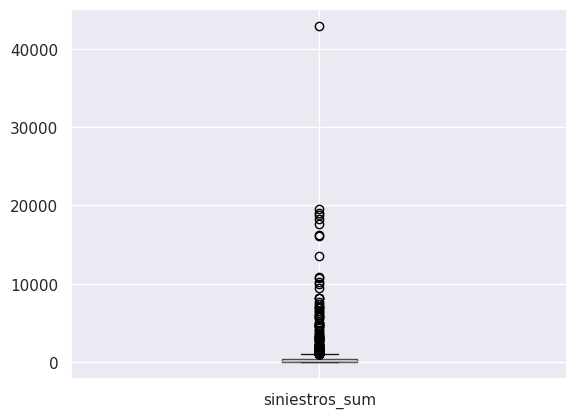

In [21]:
boxplot = data_group.boxplot(column=['siniestros_sum'])

plt.show()

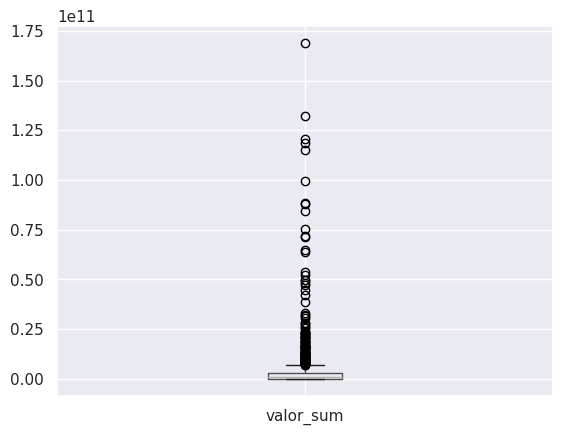

In [22]:
boxplot = data_group.boxplot(column=['valor_sum'])

plt.show()

- Como se evidencia, hay valores atípicos en las dos características

In [23]:
data.columns

Index(['ano', 'ciiu', 'siniestros', 'valor'], dtype='object')

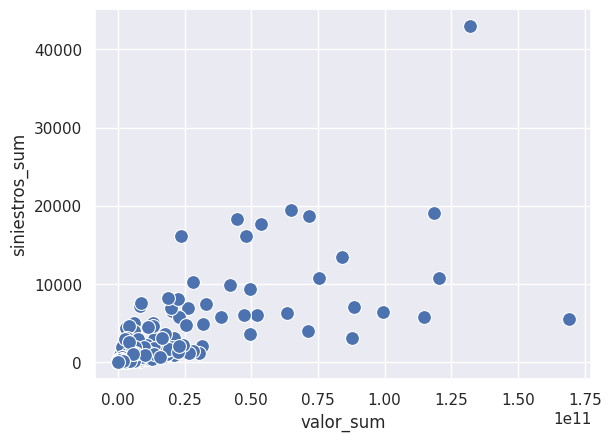

In [24]:
sns.scatterplot(
    data=data_group,
    x = 'valor_sum',
    y= 'siniestros_sum',
    palette= paleta,
    s= 100 )
plt.show()

**data split**

Definimos las posibles variables que se usan para entrenar el modelo

In [25]:
data_group.columns

Index(['ciiu', 'siniestros_sum', 'valor_sum', 'anio_count'], dtype='object')

In [26]:
X_train = data_group[['siniestros_sum', 'valor_sum', 'anio_count']]

In [27]:
X_train

,siniestros_sum,valor_sum,anio_count
0,6,"24,021,778.48",3
1,10715,"75,308,251,879.45",18
2,1,"8,144,631.00",1
3,24,"333,748,622.00",6
4,749,"11,428,924,918.76",18
...,...,...,...
804,18,"38,072,984.00",8
805,256,"851,022,510.00",11
806,20,"363,714,557.00",7
807,108,"2,097,554,597.31",16


**estandarización**

In [28]:
estimator = MinMaxScaler()
estimator.fit(X_train)
X_train = estimator.transform(X_train)


pdata = pd.DataFrame(
    X_train,
    columns=['siniestros_sum', 'valor_sum', 'anio_count'])

pdata.head()

,siniestros_sum,valor_sum,anio_count
0,0.00,0.00,0.12
1,0.25,0.45,1.00
2,0.00,0.00,0.00
3,0.00,0.00,0.29
4,0.02,0.07,1.00


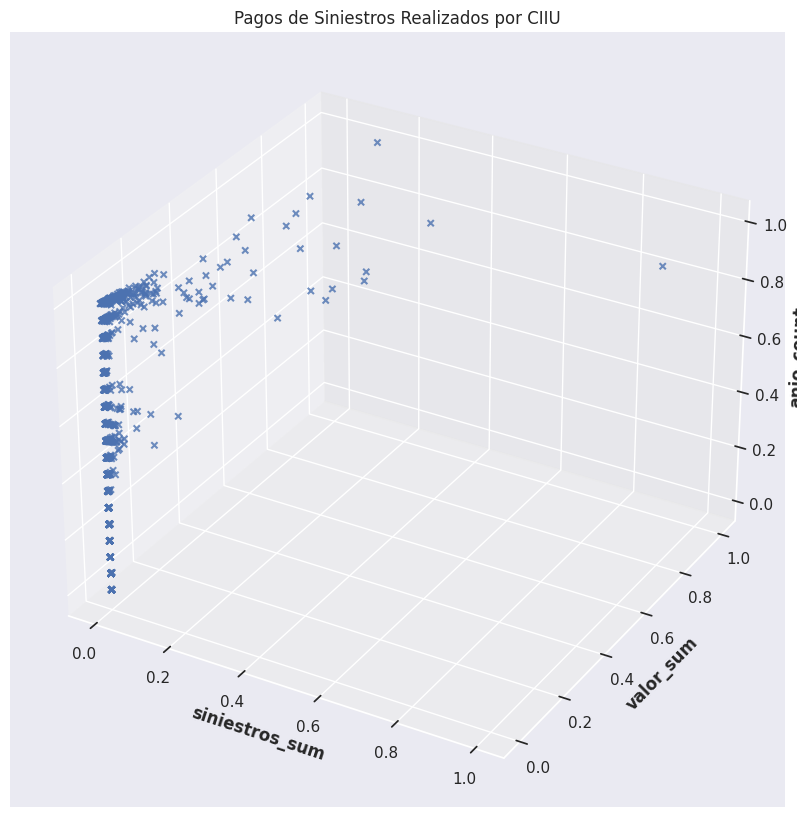

In [29]:
fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection ="3d")

x=pdata['siniestros_sum']
y=pdata['valor_sum']
z=pdata['anio_count']


my_cmap = plt.get_cmap('tab10')


sctt = ax.scatter3D(
    x,
    y,
    z,
    alpha = 0.8,

    cmap = my_cmap,
    marker ='x')


plt.title(title_data)
ax.set_xlabel('siniestros_sum', fontweight ='bold')
ax.set_ylabel('valor_sum', fontweight ='bold')
ax.set_zlabel('anio_count', fontweight ='bold')

plt.show()

Aplicando las tres variables se evidencia que no hay una porción que se separe significativamente.

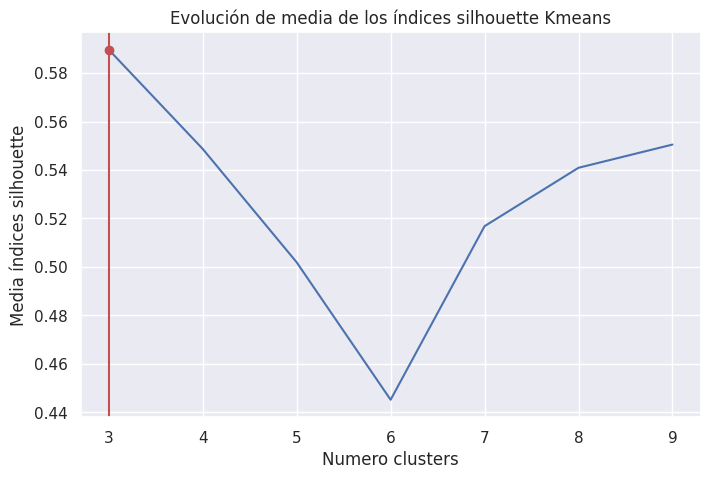

In [30]:
model = FCM(max_iter=300, m=2, random_state=12354)
silhouette_select_cluster(model, (3,10), X_train, name_model = 'Kmeans')
plt.show()

- Se selecciona un número de segmentos proporcional para que el coeficiente de silueta sea significativo y la distribución de los registros de segmentos no sean o muy grande o muy pequeños.

0.5486811246286875


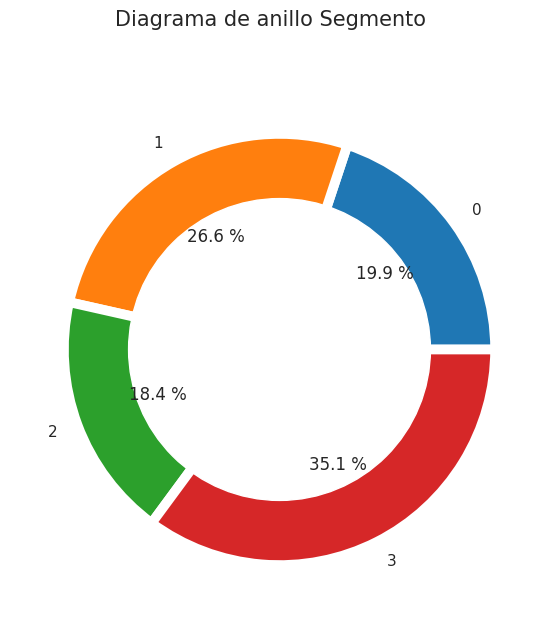

In [31]:
n_clusters = 4
model = FCM(n_clusters=n_clusters, max_iter=300, m=2, random_state=12354)

model.fit(X_train)
y_predict = model.predict(X_train)
score = silhouette_score(X_train, y_predict)
print(score)
pie_circle(pd.Series(y_predict), paleta=paleta, title='Segmento')

In [32]:
data_group['segmento'] = y_predict

In [33]:
paleta[0:4]

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

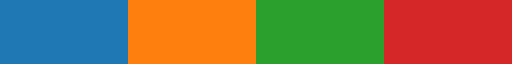

In [37]:
cmap = m.colors.ListedColormap(paleta[0:4])
cmap

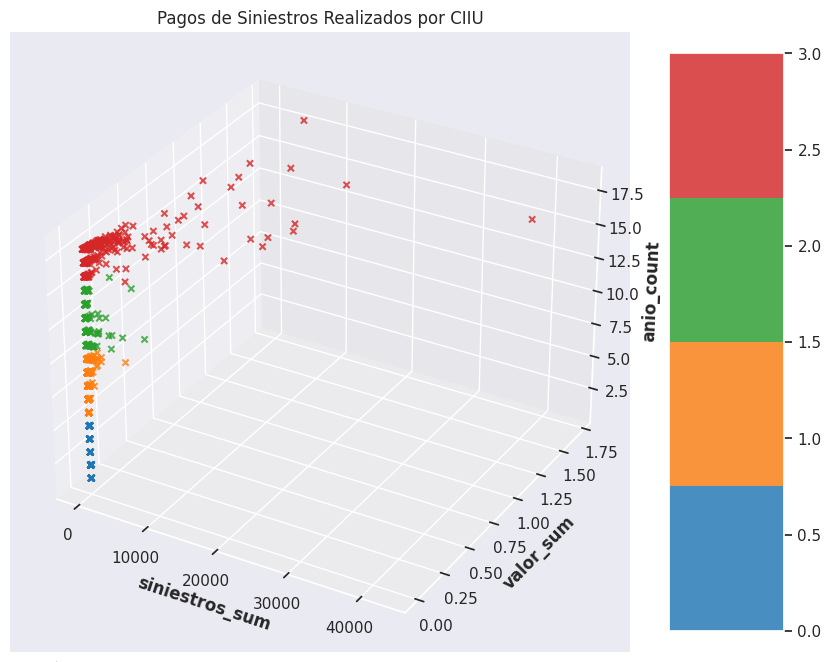

In [40]:
fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection ="3d")

x=data_group['siniestros_sum']
y=data_group['valor_sum']
z=data_group['anio_count']


my_cmap = plt.get_cmap('tab10')


sctt = ax.scatter3D(
    x,
    y,
    z,
    alpha = 0.8,
    c = data_group['segmento'],
    cmap = cmap,
    marker ='x')


plt.title(title_data)
ax.set_xlabel('siniestros_sum', fontweight ='bold')
ax.set_ylabel('valor_sum', fontweight ='bold')
ax.set_zlabel('anio_count', fontweight ='bold')
fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

Se aprecia que el algoritmo logro separar de una manera aceptable el conjunto de datos, en especial aquellos que se encuentran muy cercanos como el uno y el dos.

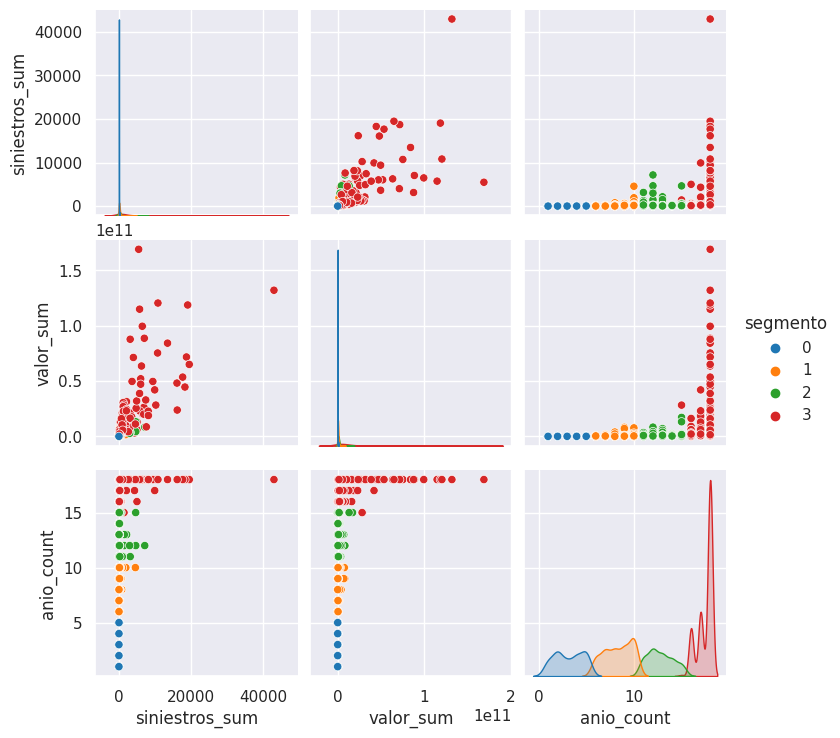

In [41]:
sns.pairplot(data_group, hue='segmento' , palette = paleta)


**Obtener los centros de cluster y los centroides de la matriz de membresía**

In [42]:
centroids = model.centers
membership_mat = model.u

In [46]:
centroids

array([[9.24824348e-04, 1.43122535e-03, 1.26735187e-01],
       [5.27681872e-03, 6.52489103e-03, 4.43276556e-01],
       [1.30283663e-02, 1.55330522e-02, 6.98611238e-01],
       [2.72998044e-02, 4.76886335e-02, 9.70957026e-01]])

Coordenadas de los tres centroides

In [44]:
data_group.iloc[1,:]

ciiu                            10
siniestros_sum               10715
valor_sum        75,308,251,879.45
anio_count                      18
segmento                         3
Name: 1, dtype: object

Grados de membresía, el segundo registro tiene aproximadamente un 45% que sea el segmento 3, el 28% un segmento 2, el 17% al segmento 1 y el 9% al segmento 0

In [57]:
membership_mat

array([[9.98833646e-01, 7.99364374e-04, 2.50986525e-04, 1.16002952e-04],
       [9.26268789e-02, 1.68278118e-01, 2.85298413e-01, 4.53796590e-01],
       [8.83704173e-01, 7.22224936e-02, 2.90630270e-02, 1.50103064e-02],
       ...,
       [1.28238063e-01, 7.99943914e-01, 5.47624722e-02, 1.70555507e-02],
       [1.25586917e-02, 3.71934602e-02, 2.11678017e-01, 7.38569831e-01],
       [8.83703672e-01, 7.22228174e-02, 2.90631609e-02, 1.50103497e-02]])

In [58]:
labels = np.argmax(membership_mat, axis=1)
labels[1]

3

- Como se valida el segundo registro es del segmento 3 por su alta probabilidad

**PC**

In [59]:
model.partition_coefficient

0.1920454464287732

- Pese a que el coeficiente de silueta indica que 3 es el grupo de segmentos idóneos para el proceso, el coeficiente de partición indica lo contrario, ya que muestra que los puntos no están bien distribuidos entre los conglomerados, por su valor muy cercano a cero.

In [60]:
model.partition_entropy_coefficient

0.16352237083561486

- Lo peculiar es que el valor PEC es cercano a cero, por lo tanto, hay homogeneidad entre los segmentos por la baja  presencia de caos de la medición de la entropía.

In [61]:
numero_segmentos = 10

models = {
    "models_i": [],
    "models_pc": [],
    "models_pec": [],
}


In [62]:
for i in range(3, numero_segmentos):
  mol = FCM(n_clusters=i, max_iter=300, m=2, random_state=12354)
  mol.fit(X_train)
  models['models_i'].append(i)
  models['models_pc'].append(mol.partition_coefficient)
  models['models_pec'].append(mol.partition_entropy_coefficient)

In [63]:
pd.DataFrame(models)

,models_i,models_pc,models_pec
0,3,0.27,0.17
1,4,0.19,0.16
2,5,0.15,0.15
3,6,0.12,0.15
4,7,0.10,0.12
5,8,0.09,0.11
6,9,0.08,0.11


Que el modelo no tiene un buen PC, pero sí un PEC. Por lo tanto, por la naturaleza de los datos no es posible una agrupación más idónea.

***Aun no lo hemos terminados, nos falta concluciones***